<a href="https://colab.research.google.com/github/m-pedram/kaggleCovid/blob/main/kaggleTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade --quiet
!pip install catboost --quiet
!pip install lightgbm --quiet
!pip install xgboost --quiet
!pip install hyperopt --quiet
!pip install mlxtend --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.1 MB/s eta 0:00:00


In [ ]:
# Import modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
%matplotlib inline
import matplotlib.ticker as ticker
import functools
from itertools import combinations
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from google.colab import files

In [ ]:
# read data from Google Drive
# from google.colab import drive 
# drive.mount('/content/drive')

data = pd.read_csv('https://raw.githubusercontent.com/m-pedram/kaggleCovid/main/Report03/rawData.csv')
filledData = data.query("PATIENT_VISIT_IDENTIFIER == 0").fillna(method='pad')
filledData = filledData.query("PATIENT_VISIT_IDENTIFIER == 0").fillna(method='backfill')
for patient_identifier in range(1,255):
  tempDf = data.query("PATIENT_VISIT_IDENTIFIER == @patient_identifier").fillna(method='pad')
  tempDf2 = tempDf.query("PATIENT_VISIT_IDENTIFIER == @patient_identifier").fillna(method='backfill')
  filledData = pd.concat([filledData, tempDf2])

pd.set_option('display.max_rows',300) # Set display rows to 300 
pd.set_option('display.max_columns',300) # Set Display columns to 300
filledData.head()
# imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# imp.fit(filledData)
# table = imp.transform(filledData)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MIN,BE_ARTERIAL_MIN,BE_VENOUS_MIN,BIC_ARTERIAL_MIN,BIC_VENOUS_MIN,BILLIRUBIN_MIN,BLAST_MIN,CALCIUM_MIN,CREATININ_MIN,FFA_MIN,GGT_MIN,GLUCOSE_MIN,HEMATOCRITE_MIN,HEMOGLOBIN_MIN,INR_MIN,LACTATE_MIN,LEUKOCYTES_MIN,LINFOCITOS_MIN,NEUTROPHILES_MIN,P02_ARTERIAL_MIN,P02_VENOUS_MIN,PC02_ARTERIAL_MIN,PC02_VENOUS_MIN,PCR_MIN,PH_ARTERIAL_MIN,PH_VENOUS_MIN,PLATELETS_MIN,POTASSIUM_MIN,SAT02_ARTERIAL_MIN,SAT02_VENOUS_MIN,SODIUM_MIN,TGO_MIN,TGP_MIN,TTPA_MIN,UREA_MIN,DIMER_MIN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU?Prediction
0,0,1,0.2,0,0,0,0,0,1,1,0,0,1,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.93895,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.0,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,1
1,0,1,0.2,0,0,0,0,0,1,1,0,0,1,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.93895,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.0,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,1
2,0,1,0.2,0,0,0,0,0,1,1,0,0,1,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.93895,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.0,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,1
3,0,1,0.2,0,0,0,0,0,1,1,0,0,1,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.93895,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.0,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.333333,-0.230769,-0.1

In [ ]:
# Create a dataframe that identify for every patient if any of its ICU values more than 0
Patient_Visit_Identifier = filledData['PATIENT_VISIT_IDENTIFIER']
filledData.drop( ['PATIENT_VISIT_IDENTIFIER'], axis = 1, inplace = True)
patients_admitted = filledData['ICU?Prediction'].sum()/ len(filledData)
print('Percentage of patients admitted to ICU : {:.2f}%'.format (patients_admitted*100))
filledData.fillna(method='ffill', inplace = True) # ffill forward filling of nulls
filledData.fillna(method='bfill', inplace = True) # bfill backward filling of nulls for the values in the first rows
filledData.isna().sum().all() 
# remove duplicate rows
print(filledData.duplicated().sum())
filledData.drop_duplicates(inplace = True)
filledData.duplicated().sum()
filledData.info(verbose= True)
ICU_admitted = filledData['ICU?Prediction']
filledData.drop( ['ICU?Prediction'], axis = 1, inplace = True)

Percentage of patients admitted to ICU : 26.92%
243
<class 'pandas.core.frame.DataFrame'>
Int64Index: 381 entries, 0 to 623
Data columns (total 85 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   AGE_ABOVE65                       381 non-null    int64  
 1   AGE_PERCENTIL                     381 non-null    float64
 2   GENDER                            381 non-null    int64  
 3   DISEASE GROUPING 1                381 non-null    int64  
 4   DISEASE GROUPING 2                381 non-null    int64  
 5   DISEASE GROUPING 3                381 non-null    int64  
 6   DISEASE GROUPING 4                381 non-null    int64  
 7   DISEASE GROUPING 5                381 non-null    int64  
 8   DISEASE GROUPING 6                381 non-null    int64  
 9   HTN                               381 non-null    int64  
 10  IMMUNOCOMPROMISED                 381 non-null    int64  
 11  OTHER              

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

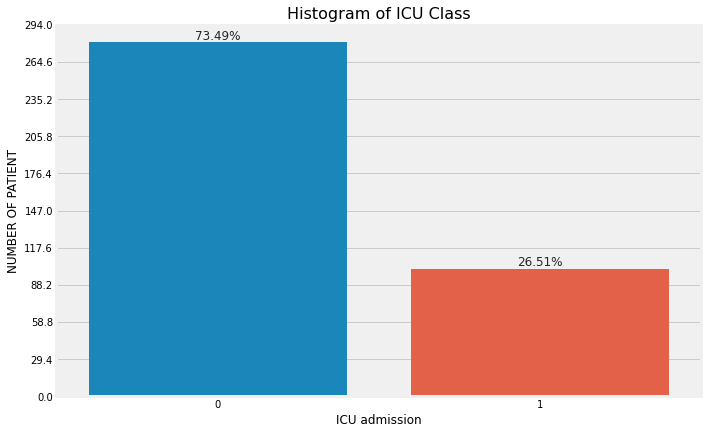

In [ ]:
plt.style.use("fivethirtyeight")
%matplotlib inline
ax = sb.countplot(ICU_admitted)
sb.set(font_scale = 1)
ax.set_xlabel("ICU admission")
ax.set_ylabel("NUMBER OF PATIENT")
fig = plt.gcf()
fig.set_size_inches(10,6)
ncount = len(ICU_admitted)
for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y),ha='center', va='bottom')  # set the alignment of the text
    
    # Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

plt.tight_layout()
plt.title('Histogram of ICU Class', fontsize=16)
plt.savefig('ICU_admission_hist.pdf', bbox_inches='tight', pad_inches=0.2)
files.download("ICU_admission_hist.pdf")
plt.show()

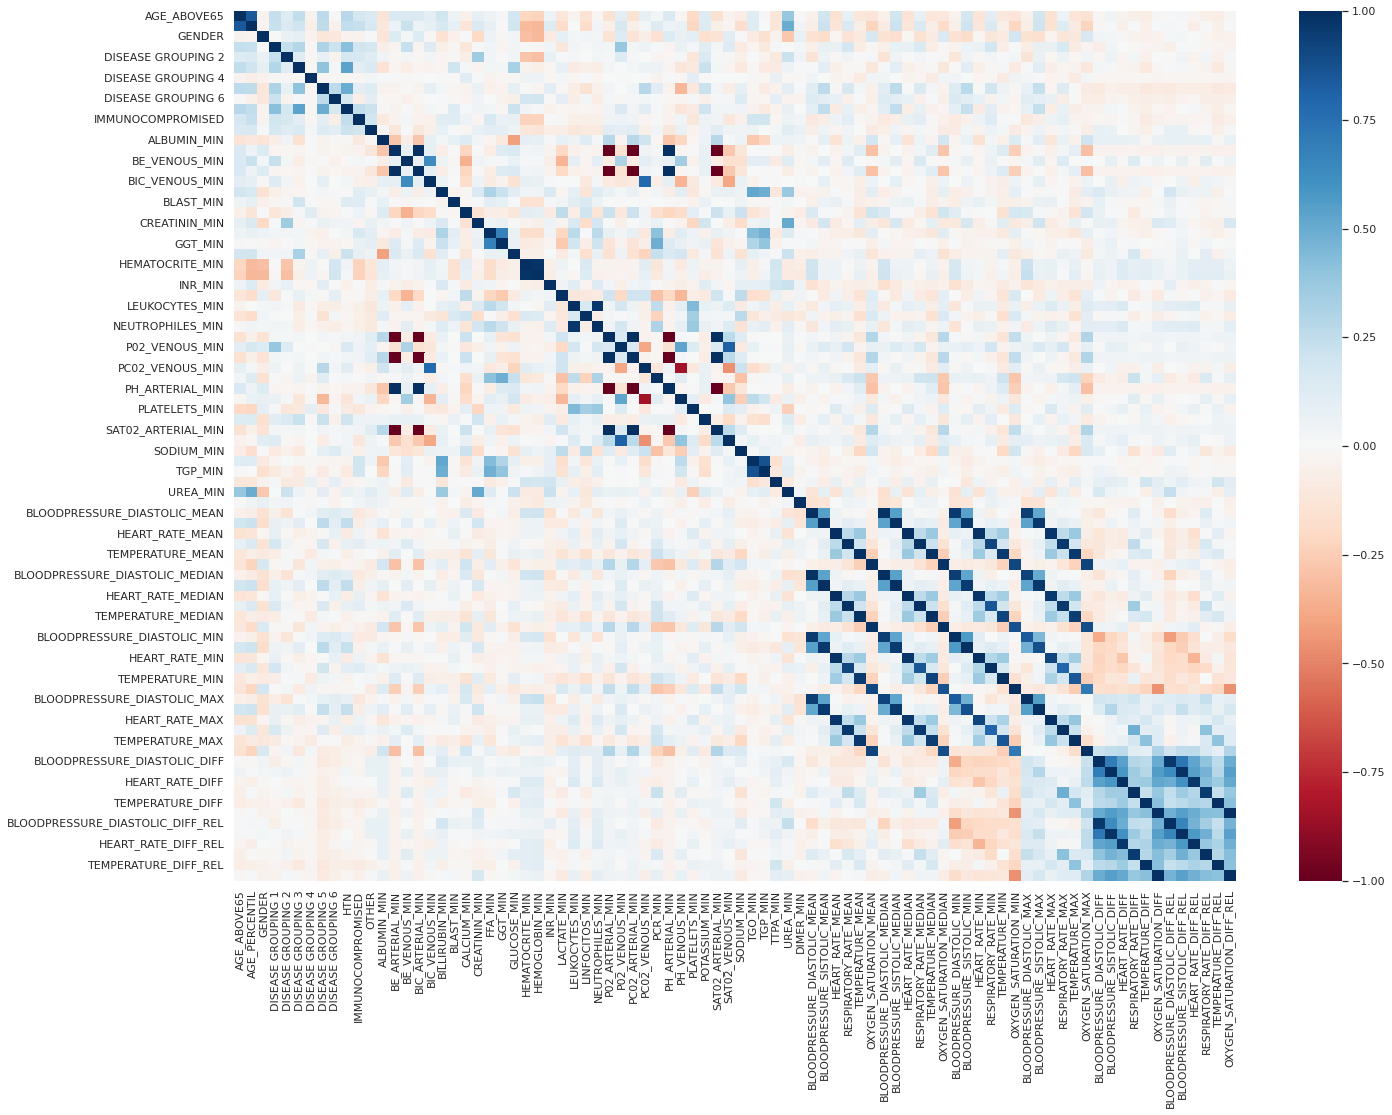

In [ ]:
from google.colab import files
df_corr = filledData.corr()
sb.set(rc={"figure.figsize": (20, 16)})
sb.heatmap(df_corr, cmap=sb.color_palette("RdBu", as_cmap=True))
# plt.savefig('correlation.png', bbox_inches='tight', pad_inches=0.2)
# files.download("correlation.png")

In [ ]:
from itertools import combinations
def check_one_to_one(df, columns):

    # Check for one column
    if len(columns) == 1:
        return True

    # Check for 2 or more columns
    result = df.groupby(columns).count()
    uniqueness = [result.index.get_level_values(
        i).is_unique for i in range(result.index.nlevels)]

    return all(uniqueness)


# Getting combinations of all the columns
combinations = list(combinations(filledData.columns, 2))

# Running to see if any of them are identical
identical_columns = []

for column in np.arange(0, len(combinations), 1):
    x = [combinations[column][0], combinations[column][1]]
    if check_one_to_one(filledData, x) == True:
        identical_columns.append(combinations[column][0])
df_new = filledData.copy()  # Copy the dataset
all_columns = [x for x in df_new.columns if x not in identical_columns]
df_new = df_new.loc[:, all_columns]

df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381 entries, 0 to 623
Data columns (total 79 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   AGE_ABOVE65                       381 non-null    int64  
 1   AGE_PERCENTIL                     381 non-null    float64
 2   GENDER                            381 non-null    int64  
 3   DISEASE GROUPING 1                381 non-null    int64  
 4   DISEASE GROUPING 2                381 non-null    int64  
 5   DISEASE GROUPING 3                381 non-null    int64  
 6   DISEASE GROUPING 4                381 non-null    int64  
 7   DISEASE GROUPING 5                381 non-null    int64  
 8   DISEASE GROUPING 6                381 non-null    int64  
 9   HTN                               381 non-null    int64  
 10  IMMUNOCOMPROMISED                 381 non-null    int64  
 11  OTHER                             381 non-null    int64  
 12  ALBUMIN_

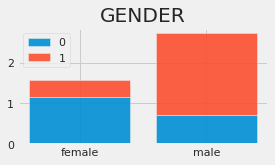

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
def normalized_stacked_bars(data, col, target):

    bottom = [0 for x in data[col].unique()]
    for cls in target.unique():
        x_vals, y_vals = np.unique(target == cls, return_counts = True)
        x_vals = [str(x) for x in x_vals] 
        y_vals = [x / y for x, y in zip(y_vals, np.unique(data[col], return_counts = True)[1])]
        
        plt.bar(x_vals, y_vals, bottom = bottom, alpha=0.9)
        bottom = [x + y for x, y in zip(bottom, y_vals)]
    ax = plt.gca()
    ax.set_xticklabels(['female', 'male'])
    plt.legend(np.unique(target))
    plt.title(col)
    
    return plt.show()

#'AGE_ABOVE65', HTN, IMMUNOCOMPROMISED
plt.style.use("fivethirtyeight")
plt.figure(figsize=(4, 2))
fig = plt.gcf()
normalized_stacked_bars(df_new, 'GENDER', ICU_admitted)


fig.savefig('GENDER.png', bbox_inches='tight', pad_inches=0.2)
files.download('GENDER.png')


In [ ]:
col_groups = [x for x in df_new.columns.values]
col_groups = np.unique(col_groups , return_counts = True)

patient_constant_cols = [col_groups[0][x] for x in range(len(col_groups[0])) if col_groups[1][x] == 1]
patient_constant_cols = [x + '_1' for x in patient_constant_cols]

time_variant_cols = [x for x in df_new.columns.values if x not in patient_constant_cols]

time_variant_groups = np.unique([x for x in time_variant_cols])
# print(time_variant_groups)
not_cluster_friendly = ['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 
                        'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 
                        'IMMUNOCOMPROMISED', 'OTHER']

clusters = np.unique([x.split('_')[-1] for x in time_variant_groups if x not in not_cluster_friendly])
print(clusters)

['ABOVE65' 'DIFF' 'GENDER' 'HTN' 'MAX' 'MEAN' 'MEDIAN' 'MIN' 'PERCENTIL'
 'REL']


19.0


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

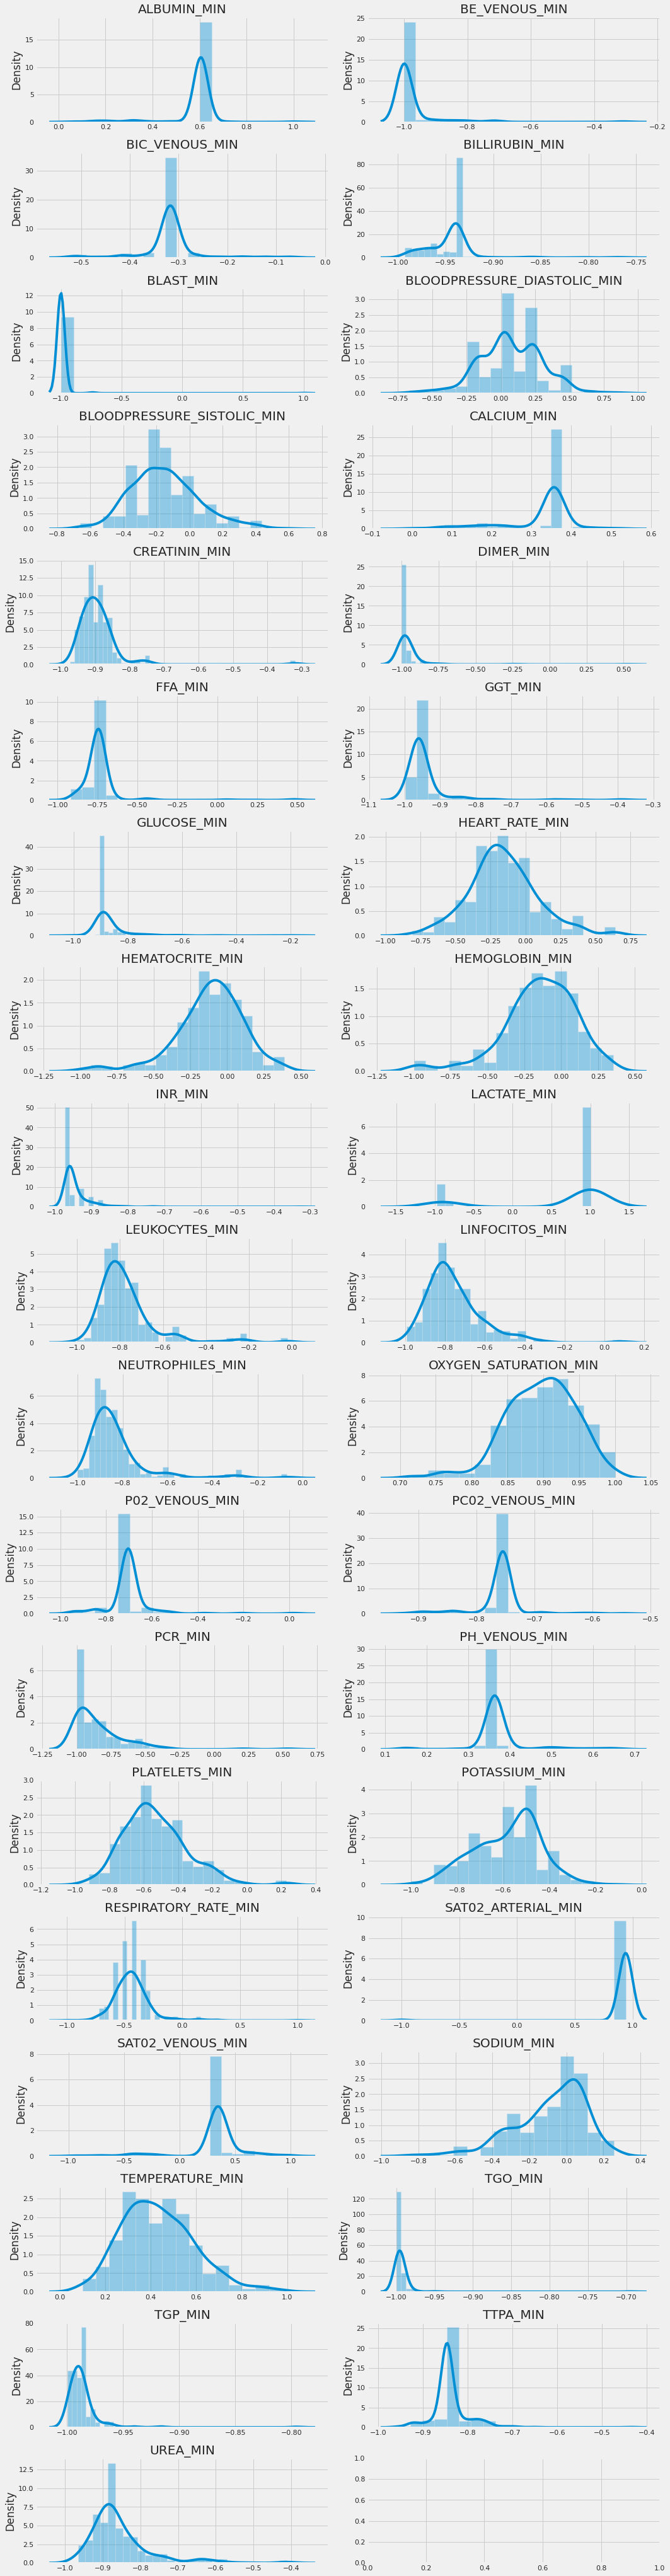

In [ ]:
#Define function to compile all values from a feature group
def extract_values_from_group(data, group_name):
    group_cols = [x for x in data.columns.values if x == group_name]
    return data[group_cols].values.reshape(-1)

#Define function to plot all feature groups from a cluster
def plot_by_cluster(data, col_groups, cluster_name):
    #Identify groups to be ploted
    groups = [x for x in col_groups if x[-len(cluster_name):] == cluster_name]
    
    #Compute dimensions for subplots
    ncols = 2
    nrows = int(len(groups) / 2) if len(groups) % 2 == 0 else np.floor(len(groups) / 2) + 1
    print(nrows)

    #Plot groups
    fig, axis = plt.subplots(nrows = int(nrows), ncols = ncols, figsize = (15, 3*nrows))
    for i, group in enumerate(groups):
        row = int(i / 2)
        col = 0 if i%2 == 0 else 1
        if data[group].dtype == np.int64:
            sb.countplot(extract_values_from_group(data, group), ax = axis[row, col]).set_title(group)
        else:
            sb.distplot(extract_values_from_group(data, group), ax = axis[row, col]).set_title(group)
    
    fig.tight_layout()
    fig.savefig('MIN.png', bbox_inches='tight', pad_inches=0.2)
    files.download('MIN.png')
    return plt.show() 

plot_by_cluster(df_new, time_variant_groups, 'MIN')


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 381 samples in 0.000s...
[t-SNE] Computed neighbors for 381 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 381 / 381
[t-SNE] Mean sigma: 1.062914
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.634964
[t-SNE] KL divergence after 850 iterations: 0.335997


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

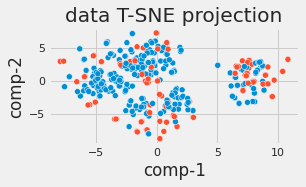

In [ ]:
#tsne 
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=100, random_state=283)
z = tsne.fit_transform(df_new)
df = pd.DataFrame()
df["y"] = ICU_admitted
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
plt.figure(figsize=(4,2))
fig = plt.gcf()
sb.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                data=df, legend=False).set(title="data T-SNE projection")
fig.savefig('Tsne_p100.png', bbox_inches='tight', pad_inches=0.2)
files.download('Tsne_p100.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

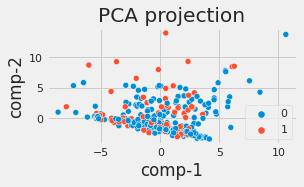

In [ ]:
#pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=2, svd_solver='full')
scaler = StandardScaler()
scaler.fit(df_new)
df_new_scaled = scaler.transform(df_new)
z = pca.fit_transform(df_new_scaled)
df = pd.DataFrame()
df["y"] = ICU_admitted
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]
plt.figure(figsize=(4,2))
fig = plt.gcf()
sb.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                data=df, legend=True).set(title="PCA projection")
fig.savefig('pca.png', bbox_inches='tight', pad_inches=0.2)
files.download('pca.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

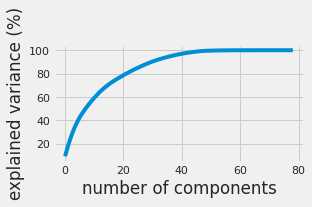

In [ ]:
pca = PCA(n_components=79, svd_solver='full')
scaler = StandardScaler()
scaler.fit(df_new)
df_new_scaled = scaler.transform(df_new)
z = pca.fit_transform(df_new_scaled)
plt.figure(figsize=(4,2))
fig = plt.gcf()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('number of components')
plt.ylabel('explained variance (%)')
fig.savefig('pca_variance.png', bbox_inches='tight', pad_inches=0.2)
files.download('pca_variance.png')
plt.show()

In [ ]:
#Define function to test algorithm
def score_model(estimator, train_data, validation_data, cv):
    #Unpack data
    X_train, y_train = train_data
    X_validation, y_validation = validation_data
    estimate = estimator
    #Perfomed cross-validation on train data
    model_cv = cross_validate(estimator = estimator, X = X_train, y = y_train,
                              scoring = ['accuracy', 'f1', 'roc_auc'],
                              cv = cv)
   
   # Generate a no skill prediction (majority class)
    no_skill_probs = [0 for _ in range(len(y_validation))]

    #Apply model to validation data
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_validation)

    # predict probabilities
    estimator_probs = estimator.predict_proba(X_validation)

    # keep probabilities for the positive outcome only
    estimator_probs = estimator_probs[:,1]

    # calculate scores
    no_skill_auc = roc_auc_score(y_validation, no_skill_probs)
    estimator_auc = roc_auc_score(y_validation, estimator_probs)

    #Print results
    print('CV model accuracy:  %{:.2f} +/- %{:.2f}'.format(model_cv['test_accuracy'].mean()*100, model_cv['test_accuracy'].std()*100))
    print('CV model f_1 score:  %{:.2f} +/- %{:.2f}'.format(model_cv['test_f1'].mean()*100, model_cv['test_f1'].std()*100))
    print('CV model roc_auc:  %{:.2f} +/- %{:.2f}'.format(model_cv['test_roc_auc'].mean()*100, model_cv['test_roc_auc'].std()*100))
    print('Validation accuracy score: %{:.2f}'.format(accuracy_score(y_validation, y_pred)*100))
    print('Validation f_1 score: %{:.2f}'.format(f1_score(y_validation, y_pred)*100))
    print('Validation ROC_AUC score: %{:.2f}'.format(roc_auc_score(y_validation, y_pred)*100))

    print("--------")
    
    # summarize scores
    print('No Skill: ROC AUC=%{:.3f}'.format((no_skill_auc)*100))
    print('{}: ROC AUC=%{:.3f}'.format(estimator , (estimator_auc)*100))

    # calculate roc curves
    no_skill_fpr, no_skill_tpr, _ = roc_curve(y_validation, no_skill_probs)
    estimator_fpr, estimator_tpr, _ = roc_curve(y_validation, estimator_probs)

    # plot the roc curve for the model
    # plt.figure(figsize=(4,2))
    # fig = plt.gcf()
    # plt.plot(no_skill_fpr, no_skill_tpr, linestyle='--', label='No Skill')
    # plt.plot(estimator_fpr, estimator_tpr, marker='.', label=estimator)

    # # axis labels
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')

    # # show the legend
    # plt.legend()
    result_to_show = [round(accuracy_score(y_validation, y_pred), 2), 
    round(f1_score(y_validation, y_pred), 2), 
    round(roc_auc_score(y_validation, y_pred),2), round(estimator_auc, 2)]
    print(result_to_show)
    
    # show the plot
    # plt.show()
    
    return estimator, estimator_auc, result_to_show

CV model accuracy:  %74.83 +/- %1.40
CV model f_1 score:  %0.00 +/- %0.00
CV model roc_auc:  %84.30 +/- %8.70
Validation accuracy score: %72.17
Validation f_1 score: %11.11
Validation ROC_AUC score: %52.94
--------
No Skill: ROC AUC=%50.000
SVC(max_iter=500, probability=True): ROC AUC=%82.607
[0.72, 0.11, 0.53]


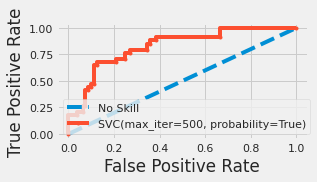

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
X = df_new
y = ICU_admitted

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.3, shuffle=True)


#Compute score for a SVM model
fitted_baseline_model_3_1, estimator_auc_3_1, dt = score_model(
    estimator=SVC(max_iter=500, probability=True),
                                      train_data=(X_train, y_train),
                                      validation_data=(
                                          X_validation, y_validation),
                                      cv=10)

In [ ]:
# data split for all experiments 
np.random.seed(42)
X = df_new
y = ICU_admitted

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.3, shuffle=True)

# perform computation on data with reduced dimension
pca = PCA(n_components=40, svd_solver='full')
scaler = StandardScaler()
scaler.fit(df_new)
df_new_scaled = scaler.transform(df_new)
X_reduced = pca.fit_transform(df_new_scaled)
np.random.seed(42)

X_reduced_train, X_reduced_validation, y_train, y_validation = train_test_split(
    X_reduced, y, test_size=0.3, shuffle=True)

CV model accuracy:  %78.55 +/- %5.48
CV model f_1 score:  %47.97 +/- %9.89
CV model roc_auc:  %85.89 +/- %9.10
Validation accuracy score: %74.78
Validation f_1 score: %45.28
Validation ROC_AUC score: %63.33
--------
No Skill: ROC AUC=%50.000
LogisticRegression(max_iter=500): ROC AUC=%80.755
[0.75, 0.45, 0.63, 0.81]
CV model accuracy:  %78.53 +/- %8.23
CV model f_1 score:  %63.44 +/- %14.18
CV model roc_auc:  %87.05 +/- %7.84
Validation accuracy score: %76.52
Validation f_1 score: %64.94
Validation ROC_AUC score: %75.65
--------
No Skill: ROC AUC=%50.000
LogisticRegression(class_weight='balanced', max_iter=500): ROC AUC=%80.973
[0.77, 0.65, 0.76, 0.81]
CV model accuracy:  %81.14 +/- %7.36
CV model f_1 score:  %58.44 +/- %19.62
CV model roc_auc:  %88.48 +/- %5.74
Validation accuracy score: %75.65
Validation f_1 score: %53.33
Validation ROC_AUC score: %67.36
--------
No Skill: ROC AUC=%50.000
LogisticRegression(max_iter=500): ROC AUC=%77.996
[0.76, 0.53, 0.67, 0.78]
CV model accuracy:  %7

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

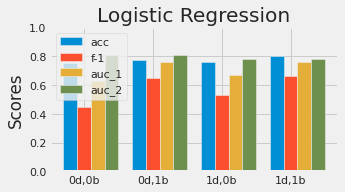

In [ ]:
# log regression
from sklearn.linear_model import LogisticRegression

data = np.zeros((4, 4))
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=LogisticRegression(max_iter=500),
                                      train_data=(X_train, y_train),
                                      validation_data=(
                                          X_validation, y_validation),
                                      cv=10)
data[:, 0] = np.array(dt).T
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=LogisticRegression(max_iter=500, class_weight='balanced'),
                                      train_data=(X_train, y_train),
                                      validation_data=(
                                          X_validation, y_validation),
                                      cv=10)
data[:, 1] = np.array(dt).T
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=LogisticRegression(max_iter=500),
                                      train_data=(X_reduced_train, y_train),
                                      validation_data=(
                                          X_reduced_validation, y_validation),
                                      cv=10)
data[:, 2] = np.array(dt).T
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=LogisticRegression(max_iter=500, class_weight='balanced'),
                                      train_data=(X_reduced_train, y_train),
                                      validation_data=(
                                          X_reduced_validation, y_validation),
                                      cv=10)
data[:, 3] = np.array(dt).T
print(data)

X = 1.25 * np.arange(4) 
fig = plt.figure(figsize=(4,2))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], width = 0.25)
ax.bar(X + 0.25, data[1], width = 0.25)
ax.bar(X + 0.50, data[2], width = 0.25)
ax.bar(X + 0.75, data[3], width = 0.25)
ax.set_ylabel('Scores')
ax.set_title('Logistic Regression')
ax.set_xticks(X+0.25)
ax.set_xticklabels(('0d,0b', '0d,1b', '1d,0b', '1d,1b'))
# ax.set_yticks(np.arange(0, 1.0, 10))
ax.set_ylim([0, 1.0])
ax.legend(labels=['acc', 'f-1', 'auc_1', 'auc_2'])
fig.savefig('logistic_results.png', bbox_inches='tight', pad_inches=0.2)
files.download('logistic_results.png')
plt.show()
# fig = plt.gcf()
# result_to_show = [round(accuracy_score(y_validation, y_pred), 2), 
# round(f1_score(y_validation, y_pred), 2), 
# round(roc_auc_score(y_validation, y_pred),2)]
# print(result_to_show)
# plt.bar(['acc', 'F-1', 'auc'], result_to_show * 100, ['acc', 'F-1', 'auc'])
# plt.title(estimator)
# fname = str(estimator) + '.png'

Saved results for further plotting: ['acc', 'f-1', 'auc']
Logistic regression

no dimension reduction, no balance: [0.75, 0.45, 0.63]

no dimension reduction, with balance: [0.77, 0.65, 0.76]

dimension reduction, no balance: [0.76, 0.53, 0.67]

dimension reduction, with balance: [0.8, 0.66, 0.76]


SVM: 

no dimension reduction, no balance: [0.72, 0.11, 0.53]

no dimension reduction, with balance: [0.7, 0.55, 0.67]

dimension reduction, no balance: [0.83, 0.6, 0.71]

dimension reduction, with balance: [0.82, 0.67, 0.76]


CV model accuracy:  %74.83 +/- %1.40
CV model f_1 score:  %0.00 +/- %0.00
CV model roc_auc:  %84.30 +/- %8.70
Validation accuracy score: %72.17
Validation f_1 score: %11.11
Validation ROC_AUC score: %52.94
--------
No Skill: ROC AUC=%50.000
SVC(max_iter=500, probability=True): ROC AUC=%82.607
[0.72, 0.11, 0.53, 0.83]
CV model accuracy:  %74.05 +/- %8.54
CV model f_1 score:  %60.01 +/- %11.63
CV model roc_auc:  %83.00 +/- %10.33
Validation accuracy score: %69.57
Validation f_1 score: %54.55
Validation ROC_AUC score: %67.30
--------
No Skill: ROC AUC=%50.000
SVC(class_weight='balanced', max_iter=500, probability=True): ROC AUC=%80.174
[0.7, 0.55, 0.67, 0.8]
CV model accuracy:  %87.95 +/- %4.74
CV model f_1 score:  %67.27 +/- %15.90
CV model roc_auc:  %91.33 +/- %6.88
Validation accuracy score: %82.61
Validation f_1 score: %60.00
Validation ROC_AUC score: %71.44
--------
No Skill: ROC AUC=%50.000
SVC(max_iter=500, probability=True): ROC AUC=%88.036
[0.83, 0.6, 0.71, 0.88]
CV model accurac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

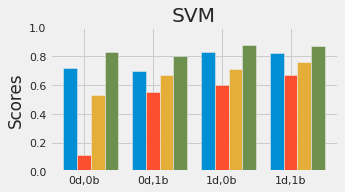

In [ ]:
# SVM
from sklearn.svm import SVC

data = np.zeros((4, 4))
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=SVC(max_iter=500, probability=True),
                                      train_data=(X_train, y_train),
                                      validation_data=(
                                          X_validation, y_validation),
                                      cv=10)
data[:, 0] = np.array(dt).T
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=SVC(max_iter=500, probability=True, class_weight='balanced'),
                                      train_data=(X_train, y_train),
                                      validation_data=(
                                          X_validation, y_validation),
                                      cv=10)
data[:, 1] = np.array(dt).T
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=SVC(max_iter=500, probability=True),
                                      train_data=(X_reduced_train, y_train),
                                      validation_data=(
                                          X_reduced_validation, y_validation),
                                      cv=10)
data[:, 2] = np.array(dt).T
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=SVC(max_iter=500, probability=True, class_weight='balanced'),
                                      train_data=(X_reduced_train, y_train),
                                      validation_data=(
                                          X_reduced_validation, y_validation),
                                      cv=10)
data[:, 3] = np.array(dt).T
print(data)

X = 1.25 * np.arange(4) 
fig = plt.figure(figsize=(4,2))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], width = 0.25)
ax.bar(X + 0.25, data[1], width = 0.25)
ax.bar(X + 0.50, data[2], width = 0.25)
ax.bar(X + 0.75, data[3], width = 0.25)
ax.set_ylabel('Scores')
ax.set_title('SVM')
ax.set_xticks(X+0.25)
ax.set_xticklabels(('0d,0b', '0d,1b', '1d,0b', '1d,1b'))
# ax.set_yticks(np.arange(0, 1.0, 10))
ax.set_ylim([0, 1.0])
# ax.legend(labels=['acc', 'f-1', 'auc_1', 'auc_2'])
fig.savefig('svm_results.png', bbox_inches='tight', pad_inches=0.2)
files.download('svm_results.png')
plt.show()

CV model accuracy:  %91.32 +/- %6.16
CV model f_1 score:  %79.07 +/- %16.71
CV model roc_auc:  %96.60 +/- %4.13
Validation accuracy score: %89.57
Validation f_1 score: %78.57
Validation ROC_AUC score: %82.35
--------
No Skill: ROC AUC=%50.000
RandomForestClassifier(): ROC AUC=%90.904
[0.9, 0.79, 0.82, 0.91]
CV model accuracy:  %89.43 +/- %4.16
CV model f_1 score:  %73.40 +/- %13.31
CV model roc_auc:  %97.83 +/- %3.07
Validation accuracy score: %86.09
Validation f_1 score: %70.37
Validation ROC_AUC score: %77.32
--------
No Skill: ROC AUC=%50.000
RandomForestClassifier(class_weight='balanced'): ROC AUC=%93.246
[0.86, 0.7, 0.77, 0.93]
CV model accuracy:  %84.63 +/- %6.27
CV model f_1 score:  %60.75 +/- %16.82
CV model roc_auc:  %90.74 +/- %5.29
Validation accuracy score: %78.26
Validation f_1 score: %50.98
Validation ROC_AUC score: %66.65
--------
No Skill: ROC AUC=%50.000
RandomForestClassifier(): ROC AUC=%88.853
[0.78, 0.51, 0.67, 0.89]
CV model accuracy:  %83.87 +/- %5.51
CV model f_1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

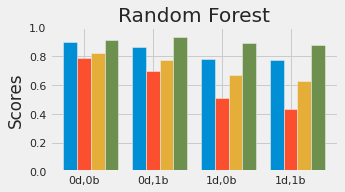

In [ ]:
# random Forest
data = np.zeros((4, 4))
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=RandomForestClassifier(),
                                      train_data=(X_train, y_train),
                                      validation_data=(
                                          X_validation, y_validation),
                                      cv=10)
data[:, 0] = np.array(dt).T
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=RandomForestClassifier(class_weight='balanced'),
                                      train_data=(X_train, y_train),
                                      validation_data=(
                                          X_validation, y_validation),
                                      cv=10)
data[:, 1] = np.array(dt).T
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=RandomForestClassifier(),
                                      train_data=(X_reduced_train, y_train),
                                      validation_data=(
                                          X_reduced_validation, y_validation),
                                      cv=10)
data[:, 2] = np.array(dt).T
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=RandomForestClassifier(class_weight='balanced'),
                                      train_data=(X_reduced_train, y_train),
                                      validation_data=(
                                          X_reduced_validation, y_validation),
                                      cv=10)
data[:, 3] = np.array(dt).T
print(data)

X = 1.25 * np.arange(4) 
fig = plt.figure(figsize=(4,2))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], width = 0.25)
ax.bar(X + 0.25, data[1], width = 0.25)
ax.bar(X + 0.50, data[2], width = 0.25)
ax.bar(X + 0.75, data[3], width = 0.25)
ax.set_ylabel('Scores')
ax.set_title('Random Forest')
ax.set_xticks(X+0.25)
ax.set_xticklabels(('0d,0b', '0d,1b', '1d,0b', '1d,1b'))
# ax.set_yticks(np.arange(0, 1.0, 10))
ax.set_ylim([0, 1.0])
# ax.legend(labels=['acc', 'f-1', 'auc_1', 'auc_2'])
fig.savefig('rf_results.png', bbox_inches='tight', pad_inches=0.2)
files.download('rf_results.png')
plt.show()


CV model accuracy:  %86.82 +/- %5.62
CV model f_1 score:  %74.46 +/- %12.48
CV model roc_auc:  %92.91 +/- %5.24
Validation accuracy score: %81.74
Validation f_1 score: %66.67
Validation ROC_AUC score: %75.94
--------
No Skill: ROC AUC=%50.000
SVC(class_weight='balanced', max_iter=500, probability=True): ROC AUC=%87.219
[0.82, 0.67, 0.76]


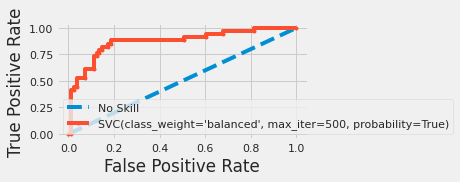

In [ ]:
# perform computation on data with reduced dimension
pca = PCA(n_components=40, svd_solver='full')
scaler = StandardScaler()
scaler.fit(df_new)
df_new_scaled = scaler.transform(df_new)
z = pca.fit_transform(df_new_scaled)
np.random.seed(42)
X = z
y = ICU_admitted

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.3, shuffle=True)


#Compute score for a SVM model
fitted_baseline_model_3_1, estimator_auc_3_1 = score_model(
    estimator=SVC(max_iter=500, probability=True, class_weight='balanced'),
                                      train_data=(X_train, y_train),
                                      validation_data=(
                                          X_validation, y_validation),
                                      cv=10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

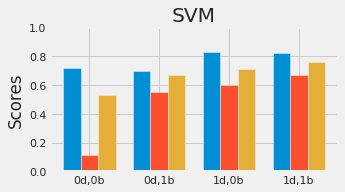

In [ ]:
# plot the results listed in the text 
# logistic regression
# data = [[0.75, 0.77, 0.76, 0.8],
# [0.45, 0.65, 0.53, 0.66],
# [0.63, 0.76, 0.67, 0.76]]

#SVM
data = [[0.72, 0.7, 0.83, 0.82],
[0.11, 0.55, 0.6, 0.67],
[0.53, 0.67, 0.71, 0.76]]

X = np.arange(4)
fig = plt.figure(figsize=(4,2))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], width = 0.25)
ax.bar(X + 0.25, data[1], width = 0.25)
ax.bar(X + 0.50, data[2], width = 0.25)
ax.set_ylabel('Scores')
ax.set_title('SVM')
ax.set_xticks(X+0.25)
ax.set_xticklabels(('0d,0b', '0d,1b', '1d,0b', '1d,1b'))
# ax.set_yticks(np.arange(0, 1.0, 10))
ax.set_ylim([0, 1.0])
# ax.legend(labels=['acc', 'f-1', 'auc'])
fig.savefig('svm_results.png', bbox_inches='tight', pad_inches=0.2)
files.download('svm_results.png')
plt.show()
# fig = plt.gcf()
# result_to_show = [round(accuracy_score(y_validation, y_pred), 2), 
# round(f1_score(y_validation, y_pred), 2), 
# round(roc_auc_score(y_validation, y_pred),2)]
# print(result_to_show)
# plt.bar(['acc', 'F-1', 'auc'], result_to_show * 100, ['acc', 'F-1', 'auc'])
# plt.title(estimator)
# fname = str(estimator) + '.png'
# 

CV model accuracy:  %92.85 +/- %4.56
CV model f_1 score:  %82.87 +/- %11.82
CV model roc_auc:  %97.72 +/- %2.65
Validation accuracy score: %89.57
Validation f_1 score: %78.57
Validation ROC_AUC score: %82.35
--------
No Skill: ROC AUC=%50.000
RandomForestClassifier(): ROC AUC=%92.121
[0.9, 0.79, 0.82]


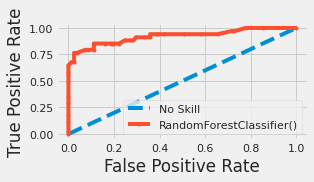

In [ ]:
# random forest 
np.random.seed(42)
X = df_new
y = ICU_admitted

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.3, shuffle=True)
baseline_model_2 = RandomForestClassifier()
fitted_baseline_model_1_2, estimator_auc_1_2 = score_model(estimator=baseline_model_2,
                                      train_data = (X_train, y_train),
                                      validation_data = (X_validation, y_validation),
                                      cv = 10)

In [ ]:
print(fitted_baseline_model_1_2.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


CV model accuracy:  %82.75 +/- %4.00
CV model f_1 score:  %46.72 +/- %16.08
CV model roc_auc:  %92.55 +/- %6.15
Validation accuracy score: %80.00
Validation f_1 score: %48.89
Validation ROC_AUC score: %66.18
--------
No Skill: ROC AUC=%50.000
RandomForestClassifier(class_weight='balanced'): ROC AUC=%88.598
[0.8, 0.49, 0.66]


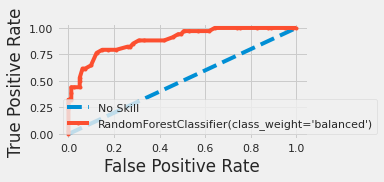

In [ ]:
# perform computation on data with reduced dimension
pca = PCA(n_components=40, svd_solver='full')
scaler = StandardScaler()
scaler.fit(df_new)
df_new_scaled = scaler.transform(df_new)
z = pca.fit_transform(df_new_scaled)
np.random.seed(42)
X = z
y = ICU_admitted

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.3, shuffle=True)
baseline_model_2 = RandomForestClassifier(class_weight='balanced')
fitted_baseline_model_1_3, estimator_auc_1_3 = score_model(estimator=baseline_model_2,
                                      train_data = (X_train, y_train),
                                      validation_data = (X_validation, y_validation),
                                      cv = 10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

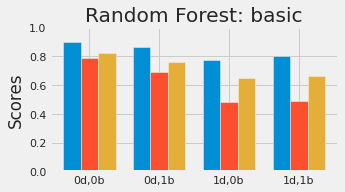

In [ ]:
data = [[0.9, 0.86, 0.77, 0.8],
[0.79, 0.69, 0.48, 0.49],
[0.82, 0.76, 0.65, 0.66]]
X = np.arange(4)
fig = plt.figure(figsize=(4,2))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], width = 0.25)
ax.bar(X + 0.25, data[1], width = 0.25)
ax.bar(X + 0.50, data[2], width = 0.25)
ax.set_ylabel('Scores')
ax.set_title('Random Forest: basic')
ax.set_xticks(X+0.25)
ax.set_xticklabels(('0d,0b', '0d,1b', '1d,0b', '1d,1b'))
# ax.set_yticks(np.arange(0, 1.0, 10))
ax.set_ylim([0, 1.0])
# ax.legend(labels=['acc', 'f-1', 'auc'])
fig.savefig('randomForestBasic_results.png', bbox_inches='tight', pad_inches=0.2)
files.download('randomForestBasic_results.png')
plt.show()

CV model accuracy:  %91.74 +/- %3.24
CV model f_1 score:  %80.68 +/- %9.27
CV model roc_auc:  %97.61 +/- %3.07
Validation accuracy score: %87.83
Validation f_1 score: %75.00
Validation ROC_AUC score: %80.27
--------
No Skill: ROC AUC=%50.000
RandomForestClassifier(): ROC AUC=%91.703
[0.88, 0.75, 0.8, 0.92]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

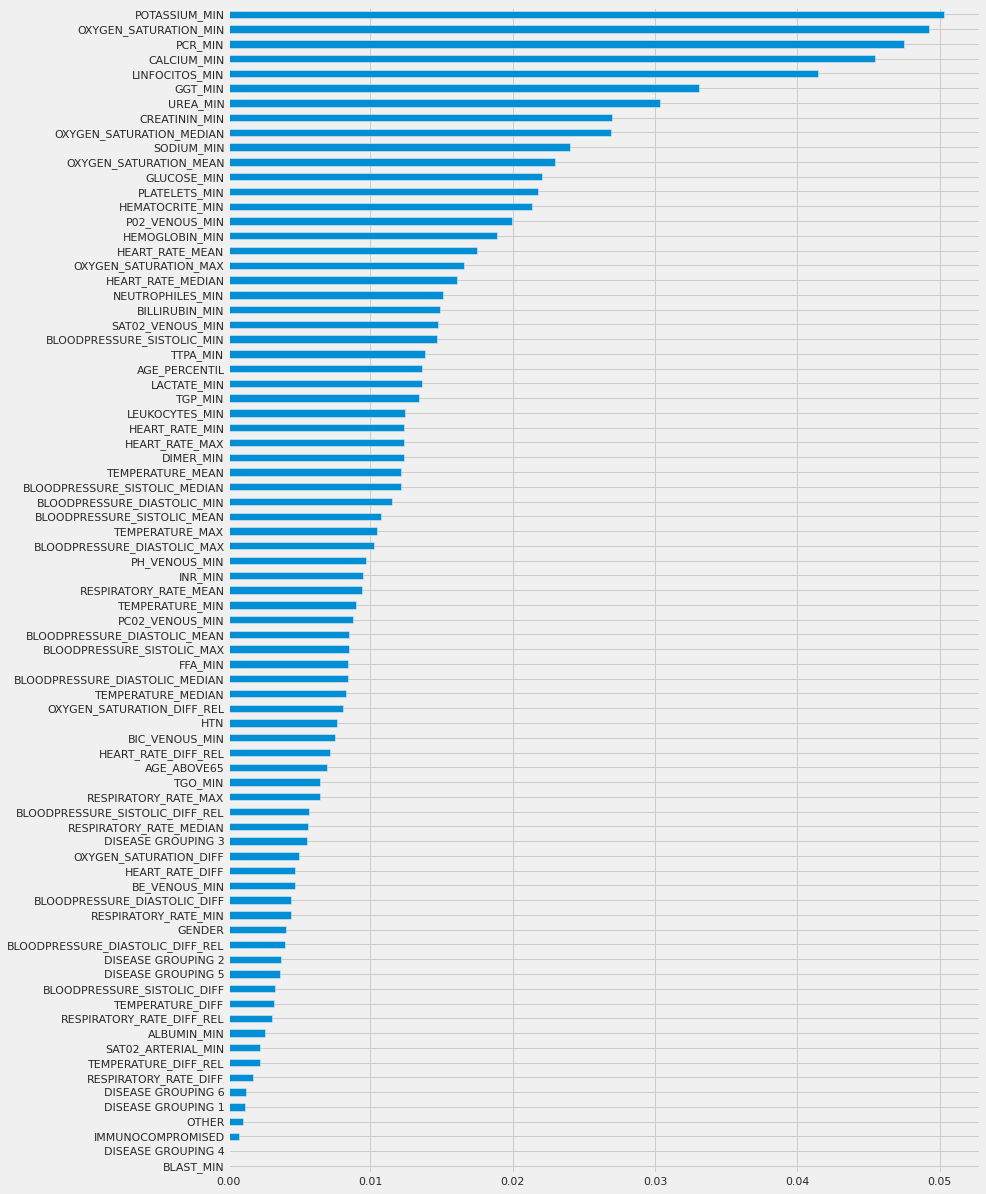

In [ ]:
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=RandomForestClassifier(),
                                      train_data=(X_train, y_train),
                                      validation_data=(
                                          X_validation, y_validation),
                                      cv=10)
fig = plt.figure(figsize=(12,20))
feat_importances = pd.Series(data = fitted_baseline_model_1_1.feature_importances_,
                            index = df_new.columns).sort_values()
feat_importances.plot(kind = "barh")
fig.savefig('randomForestFeatureRank.png', bbox_inches='tight', pad_inches=0.2)
files.download('randomForestFeatureRank.png')
plt.show()

In [ ]:
#Test RandomForest model for reduced dataset
ncols_to_keep = int(0.8 * len(feat_importances))
reduced_feat_columns = feat_importances.nlargest(n = ncols_to_keep).index

reduced_x_train = X_train[reduced_feat_columns]
reduced_x_validation = X_validation[reduced_feat_columns]

fitted_baseline_model_1_3, estimator_auc_1_3, dt = score_model(estimator=RandomForestClassifier(),
                                      train_data = (reduced_x_train, y_train),
                                      validation_data = (reduced_x_validation, y_validation),
                                      cv = 10)

CV model accuracy:  %92.09 +/- %3.93
CV model f_1 score:  %82.01 +/- %9.46
CV model roc_auc:  %97.43 +/- %3.18
Validation accuracy score: %86.09
Validation f_1 score: %71.43
Validation ROC_AUC score: %78.18
--------
No Skill: ROC AUC=%50.000
RandomForestClassifier(): ROC AUC=%91.576
[0.86, 0.71, 0.78, 0.92]


In [ ]:
#Get RFE feature ranking and compare to RandomForestClassifier feature importance
rfe_model = RandomForestClassifier(n_estimators = 10)
feature_selector = RFE(estimator = rfe_model, step = 1)
feature_selector.fit(X_train, y_train)
feature_ranking = pd.Series(data = feature_selector.ranking_, index = df_new.columns).sort_values()

importance_scale = pd.concat([feature_ranking, feat_importances.rank(ascending = False)], axis = 1)
importance_scale = importance_scale.rename(columns = {0: 'RFE_ranking', 1: 'RFC_ranking'})
importance_scale.sort_values(by = ['RFE_ranking', 'RFC_ranking'])

,RFE_ranking,RFC_ranking
POTASSIUM_MIN,1,1.0
OXYGEN_SATURATION_MIN,1,2.0
PCR_MIN,1,3.0
CALCIUM_MIN,1,4.0
LINFOCITOS_MIN,1,5.0
GGT_MIN,1,6.0
UREA_MIN,1,7.0
CREATININ_MIN,1,8.0
OXYGEN_SATURATION_MEDIAN,1,9.0
SODIUM_MIN,1,10.0


In [ ]:
#Test RandomForest model for RFE reduced dataset
cols_to_keep = importance_scale[importance_scale['RFE_ranking'] == 1].index
reduced_x_train = X_train[cols_to_keep]
reduced_x_validation = X_validation[cols_to_keep]

fitted_baseline_model_1_4, estimator_auc_1_4, dt = score_model(estimator=RandomForestClassifier(),
                                      train_data = (reduced_x_train, y_train),
                                      validation_data = (reduced_x_validation, y_validation),
                                      cv = 10)

CV model accuracy:  %91.71 +/- %4.42
CV model f_1 score:  %80.74 +/- %12.19
CV model roc_auc:  %98.00 +/- %2.70
Validation accuracy score: %87.83
Validation f_1 score: %75.86
Validation ROC_AUC score: %81.12
--------
No Skill: ROC AUC=%50.000
RandomForestClassifier(): ROC AUC=%92.357
[0.88, 0.76, 0.81, 0.92]


In [ ]:
# Define hyperparameter space
hyperparameter_grid = {
    'n_estimators': [10, 100, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'max_features': ['sqrt', 'log2', None]
}

In [ ]:
# Perform hyperparameter tuning by grid searching the defined space
np.random.seed(42)
# X = df_new
# y = ICU_admitted

# X_train, X_validation, y_train, y_validation = train_test_split(
#     X, y, test_size=0.3, shuffle=True)
grid_search = GridSearchCV(estimator = RandomForestClassifier(),
                           param_grid = hyperparameter_grid,
                           scoring = "roc_auc",
                           cv = 10,
                           n_jobs = 4,
                           verbose = 1)

grid_search_results = grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap='True', class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='sqrt')>
Validation accuracy: %86.09
Validation f1_score: %71.43
Validation ROC_AUC: %78.18
-----
No Skill: ROC AUC=%50.000
RandomForestClassifier: ROC AUC=%94.045


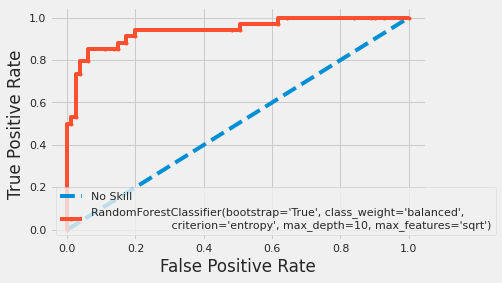

In [ ]:
# Look at the best performing set of hyperparameters and apply estimator on valdiation data
print(grid_search.best_params_)

best_gridsearch_model = grid_search.best_estimator_
print(best_gridsearch_model.get_params)
best_gridsearch_model.fit(X_train, y_train)
y_pred = best_gridsearch_model.predict(X_validation)

print("Validation accuracy: %{:.2f}".format((accuracy_score(y_validation, y_pred))*100))
print("Validation f1_score: %{:.2f}".format((f1_score(y_validation, y_pred))*100))
print("Validation ROC_AUC: %{:.2f}".format((roc_auc_score(y_validation, y_pred))*100))

# Generate a no skill prediction (majority class)
no_skill_probs = [0 for _ in range(len(y_validation))]

# predict probabilities
best_gridsearch_model_probs = best_gridsearch_model.predict_proba(X_validation)

# keep probabilities for the positive outcome only
best_gridsearch_model_probs = best_gridsearch_model_probs[:,1]

# calculate scores
no_skill_auc_1 = roc_auc_score(y_validation, no_skill_probs)
best_gridsearch_model_auc_1 = roc_auc_score(y_validation, best_gridsearch_model_probs)

print("-----")

# summarize scores
print('No Skill: ROC AUC=%{:.3f}'.format((no_skill_auc_1)*100))
print('RandomForestClassifier: ROC AUC=%{:.3f}'.format((best_gridsearch_model_auc_1)*100))

# calculate roc curves
no_skill_fpr, no_skill_tpr, _ = roc_curve(y_validation, no_skill_probs)
best_gridsearch_model_fpr, best_gridsearch_model_tpr, _ = roc_curve(y_validation, best_gridsearch_model_probs)

# plot the roc curve for the model
plt.plot(no_skill_fpr, no_skill_tpr, linestyle='--', label='No Skill')
plt.plot(best_gridsearch_model_fpr, best_gridsearch_model_tpr, marker='.', label=best_gridsearch_model)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

CV model accuracy:  %92.09 +/- %5.16
CV model f_1 score:  %81.06 +/- %12.49
CV model roc_auc:  %96.76 +/- %4.28
Validation accuracy score: %86.96
Validation f_1 score: %73.68
Validation ROC_AUC score: %79.65
--------
No Skill: ROC AUC=%50.000
RandomForestClassifier(bootstrap='False', criterion='entropy', max_depth=10,
                       max_features='sqrt'): ROC AUC=%92.484
[0.87, 0.74, 0.8, 0.92]
CV model accuracy:  %91.70 +/- %5.34
CV model f_1 score:  %78.67 +/- %15.97
CV model roc_auc:  %97.74 +/- %2.88
Validation accuracy score: %86.09
Validation f_1 score: %70.37
Validation ROC_AUC score: %77.32
--------
No Skill: ROC AUC=%50.000
RandomForestClassifier(bootstrap='False', class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='sqrt'): ROC AUC=%95.570
[0.86, 0.7, 0.77, 0.96]
CV model accuracy:  %84.62 +/- %4.17
CV model f_1 score:  %58.95 +/- %11.63
CV model roc_auc:  %92.92 +/- %3.71
Validation accuracy score: %79.13
Validation f_1 scor

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

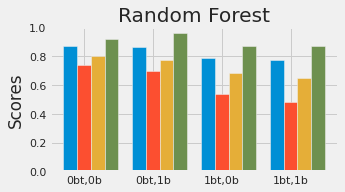

In [ ]:
data = np.zeros((4, 4))
best_gridsearch_model = grid_search.best_estimator_

model1 = best_gridsearch_model 
model1.bootstrap='False'
model1.class_weight=None
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=model1,
                                      train_data=(X_train, y_train),
                                      validation_data=(
                                          X_validation, y_validation),
                                      cv=10)
data[:, 0] = np.array(dt).T
model2 = best_gridsearch_model 
model2.bootstrap='False'
model2.class_weight='balanced'
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=model2,
                                      train_data=(X_train, y_train),
                                      validation_data=(
                                          X_validation, y_validation),
                                      cv=10)
data[:, 1] = np.array(dt).T
model3 = best_gridsearch_model 
model3.bootstrap='True'
model3.class_weight=None
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=model3,
                                      train_data=(X_reduced_train, y_train),
                                      validation_data=(
                                          X_reduced_validation, y_validation),
                                      cv=10)
data[:, 2] = np.array(dt).T
model4 = best_gridsearch_model 
model4.bootstrap='True'
model4.class_weight='balanced'
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=model4,
                                      train_data=(X_reduced_train, y_train),
                                      validation_data=(
                                          X_reduced_validation, y_validation),
                                      cv=10)
data[:, 3] = np.array(dt).T
print(data)

X = 1.25 * np.arange(4) 
fig = plt.figure(figsize=(4,2))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], width = 0.25)
ax.bar(X + 0.25, data[1], width = 0.25)
ax.bar(X + 0.50, data[2], width = 0.25)
ax.bar(X + 0.75, data[3], width = 0.25)
ax.set_ylabel('Scores')
ax.set_title('Random Forest')
ax.set_xticks(X+0.25)
ax.set_xticklabels(('0bt,0b', '0bt,1b', '1bt,0b', '1bt,1b'))
# ax.set_yticks(np.arange(0, 1.0, 10))
ax.set_ylim([0, 1.0])
# ax.legend(labels=['acc', 'f-1', 'auc_1', 'auc_2'])
fig.savefig('rfn_results.png', bbox_inches='tight', pad_inches=0.2)
files.download('rfn_results.png')
plt.show()

In [ ]:
baseline_model_3 = XGBClassifier(objective='binary:logistic')
fitted_baseline_model_1_3, estimator_auc_1_3, dt = score_model(estimator=baseline_model_3,
                                      train_data = (X_train, y_train),
                                      validation_data = (X_validation, y_validation),
                                      cv = 10)

CV model accuracy:  %92.05 +/- %4.37
CV model f_1 score:  %81.76 +/- %11.43
CV model roc_auc:  %97.70 +/- %2.29
Validation accuracy score: %90.43
Validation f_1 score: %81.36
Validation ROC_AUC score: %84.68
--------
No Skill: ROC AUC=%50.000
XGBClassifier(): ROC AUC=%94.263
[0.9, 0.81, 0.85, 0.94]


In [ ]:
hyperparameter_grid = {
    'n_estimators': [10, 100],
    'criterion': ['gini', 'entropy'],
    # 'max_depth': [3, 5, None]
    'max_features': ['sqrt', 'log2', None]}
grid_search = GridSearchCV(estimator = XGBClassifier(),
                           param_grid = hyperparameter_grid,
                           scoring = "roc_auc",
                           cv = 10,
                           n_jobs = 4,
                           verbose = 1)

grid_search_results = grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
Validation accuracy: %90.43
Validation f1_score: %81.36
Validation ROC_AUC: %84.68
-----
No Skill: ROC AUC=%50.000
XGBClassifier: ROC AUC=%94.263


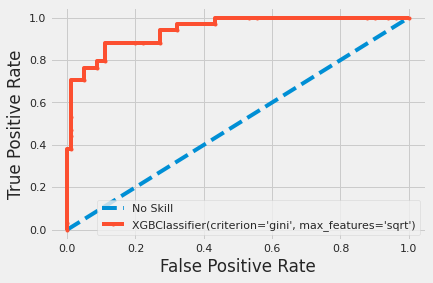

In [ ]:
# Look at the best performing set of hyperparameters and apply estimator on valdiation data
print(grid_search.best_params_)

best_gridsearch_model = grid_search.best_estimator_
best_gridsearch_model.fit(X_train, y_train)
y_pred = best_gridsearch_model.predict(X_validation)

print("Validation accuracy: %{:.2f}".format((accuracy_score(y_validation, y_pred))*100))
print("Validation f1_score: %{:.2f}".format((f1_score(y_validation, y_pred))*100))
print("Validation ROC_AUC: %{:.2f}".format((roc_auc_score(y_validation, y_pred))*100))

# Generate a no skill prediction (majority class)
no_skill_probs = [0 for _ in range(len(y_validation))]

# predict probabilities
best_gridsearch_model_probs = best_gridsearch_model.predict_proba(X_validation)

# keep probabilities for the positive outcome only
best_gridsearch_model_probs = best_gridsearch_model_probs[:,1]

# calculate scores
no_skill_auc_1 = roc_auc_score(y_validation, no_skill_probs)
best_gridsearch_model_auc_1 = roc_auc_score(y_validation, best_gridsearch_model_probs)

print("-----")

# summarize scores
print('No Skill: ROC AUC=%{:.3f}'.format((no_skill_auc_1)*100))
print('XGBClassifier: ROC AUC=%{:.3f}'.format((best_gridsearch_model_auc_1)*100))

# calculate roc curves
no_skill_fpr, no_skill_tpr, _ = roc_curve(y_validation, no_skill_probs)
best_gridsearch_model_fpr, best_gridsearch_model_tpr, _ = roc_curve(y_validation, best_gridsearch_model_probs)

# plot the roc curve for the model
plt.plot(no_skill_fpr, no_skill_tpr, linestyle='--', label='No Skill')
plt.plot(best_gridsearch_model_fpr, best_gridsearch_model_tpr, marker='.', label=best_gridsearch_model)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

CV model accuracy:  %92.05 +/- %4.37
CV model f_1 score:  %81.76 +/- %11.43
CV model roc_auc:  %97.70 +/- %2.29
Validation accuracy score: %90.43
Validation f_1 score: %81.36
Validation ROC_AUC score: %84.68
--------
No Skill: ROC AUC=%50.000
XGBClassifier(criterion='gini', max_features='sqrt'): ROC AUC=%94.263
[0.9, 0.81, 0.85, 0.94]
CV model accuracy:  %92.05 +/- %4.37
CV model f_1 score:  %81.76 +/- %11.43
CV model roc_auc:  %97.70 +/- %2.29
Validation accuracy score: %90.43
Validation f_1 score: %81.36
Validation ROC_AUC score: %84.68
--------
No Skill: ROC AUC=%50.000
XGBClassifier(criterion='gini', max_features='sqrt'): ROC AUC=%94.263
[0.9, 0.81, 0.85, 0.94]
CV model accuracy:  %86.48 +/- %6.55
CV model f_1 score:  %66.35 +/- %18.95
CV model roc_auc:  %89.57 +/- %6.50
Validation accuracy score: %80.00
Validation f_1 score: %58.18
Validation ROC_AUC score: %70.44
--------
No Skill: ROC AUC=%50.000
XGBClassifier(criterion='gini', max_features='sqrt'): ROC AUC=%87.945
[0.8, 0.58, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

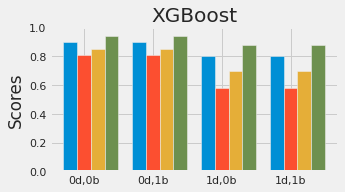

In [ ]:
data = np.zeros((4, 4))
best_gridsearch_model.class_weight=None
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=best_gridsearch_model,
                                      train_data=(X_train, y_train),
                                      validation_data=(
                                          X_validation, y_validation),
                                      cv=10)
data[:, 0] = np.array(dt).T
best_gridsearch_model.class_weight='balanced'
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=best_gridsearch_model,
                                      train_data=(X_train, y_train),
                                      validation_data=(
                                          X_validation, y_validation),
                                      cv=10)
data[:, 1] = np.array(dt).T
best_gridsearch_model.class_weight=None
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=best_gridsearch_model,
                                      train_data=(X_reduced_train, y_train),
                                      validation_data=(
                                          X_reduced_validation, y_validation),
                                      cv=10)
data[:, 2] = np.array(dt).T
best_gridsearch_model.class_weight='balanced'
fitted_baseline_model_1_1, estimator_auc_1_1, dt = score_model(
    estimator=best_gridsearch_model,
                                      train_data=(X_reduced_train, y_train),
                                      validation_data=(
                                          X_reduced_validation, y_validation),
                                      cv=10)
data[:, 3] = np.array(dt).T
print(data)

X = 1.25 * np.arange(4) 
fig = plt.figure(figsize=(4,2))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], width = 0.25)
ax.bar(X + 0.25, data[1], width = 0.25)
ax.bar(X + 0.50, data[2], width = 0.25)
ax.bar(X + 0.75, data[3], width = 0.25)
ax.set_ylabel('Scores')
ax.set_title('XGBoost')
ax.set_xticks(X+0.25)
ax.set_xticklabels(('0d,0b', '0d,1b', '1d,0b', '1d,1b'))
# ax.set_yticks(np.arange(0, 1.0, 10))
ax.set_ylim([0, 1.0])
# ax.legend(labels=['acc', 'f-1', 'auc_1', 'auc_2'])
fig.savefig('xgb_results.png', bbox_inches='tight', pad_inches=0.2)
files.download('xgb_results.png')
plt.show()


In [ ]:
# all models 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

results = np.zeros((4, 4, 1))
X = df_new
y = ICU_admitted

model_1 = LogisticRegression(max_iter=500)
model_2 = SVC(max_iter=500, probability=True)
model_3 = RandomForestClassifier(n_estimators=100, criterion='entropy',
                                 max_depth=None, max_features='sqrt')
model_4 = XGBClassifier(n_estimators=100, criterion='gini', 
                        max_features='sqrt')




for i in range(1):
  np.random.seed(42)

  # perform computation on data with reduced dimension
  pca = PCA(n_components=40, svd_solver='full')
  scaler = StandardScaler()
  scaler.fit(df_new)
  df_new_scaled = scaler.transform(df_new)
  X_reduced = pca.fit_transform(df_new_scaled)
  np.random.seed(42)

  X_train, X_validation, y_train, y_validation = train_test_split(
      X, y, test_size=0.3, shuffle=True)

  X_reduced_train, X_reduced_validation, y_train, y_validation = train_test_split(
      X_reduced, y, test_size=0.3, shuffle=True)
  
  fitted_baseline_model_1, estimator_auc_1, dt_1 = score_model(
    estimator=model_1,
                    train_data=(X_train, y_train),
                    validation_data=(
                        X_validation, y_validation),
                    cv=10)
  fitted_baseline_model_2, estimator_auc_2, dt_2 = score_model(
    estimator=model_2,
                    train_data=(X_reduced_train, y_train),
                    validation_data=(
                        X_reduced_validation, y_validation),
                    cv=10)
  fitted_baseline_model_3, estimator_auc_3, dt_3 = score_model(
    estimator=model_3,
                    train_data=(X_train, y_train),
                    validation_data=(
                        X_validation, y_validation),
                    cv=10)
  model_4.seed = 42
  fitted_baseline_model_4, estimator_auc_4, dt_4 = score_model(
    estimator=model_4,
                    train_data=(X_train, y_train),
                    validation_data=(
                        X_validation, y_validation),
                    cv=10)
    
  results[:, 0, i] = np.array(dt_1).T
  results[:, 1, i] = np.array(dt_2).T
  results[:, 2, i] = np.array(dt_3).T
  results[:, 3, i] = np.array(dt_4).T


CV model accuracy:  %67.69 +/- %4.27
CV model f_1 score:  %4.04 +/- %8.13
CV model roc_auc:  %40.21 +/- %10.90
Validation accuracy score: %75.65
Validation f_1 score: %0.00
Validation ROC_AUC score: %48.33
--------
No Skill: ROC AUC=%50.000
LogisticRegression(max_iter=500): ROC AUC=%34.800
[0.76, 0.0, 0.48, 0.35]
CV model accuracy:  %83.48 +/- %5.57
CV model f_1 score:  %60.75 +/- %18.59
CV model roc_auc:  %87.87 +/- %10.43
Validation accuracy score: %86.96
Validation f_1 score: %59.46
Validation ROC_AUC score: %71.44
--------
No Skill: ROC AUC=%50.000
SVC(max_iter=500, probability=True): ROC AUC=%93.200
[0.87, 0.59, 0.71, 0.93]
CV model accuracy:  %68.05 +/- %4.46
CV model f_1 score:  %14.49 +/- %13.09
CV model roc_auc:  %47.78 +/- %10.19
Validation accuracy score: %73.91
Validation f_1 score: %21.05
Validation ROC_AUC score: %53.00
--------
No Skill: ROC AUC=%50.000
RandomForestClassifier(criterion='entropy', max_features='sqrt'): ROC AUC=%56.800
[0.74, 0.21, 0.53, 0.57]
CV model acc